# GMM

**CONGNARD Thomas**

# Librairies

In [ ]:
# Packages
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
import datetime as D
import numpy as np
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from hmmlearn import hmm

## Récupération des données

In [4]:
#Récupération des données excel
path = r"Donnees_Indices_Bloomberg.xlsx"
data = pd.read_excel(path)
data

,Domaine,Equity,FX,Commodities,Rates,Inflation,Emerging Markets,US Corporate IG
0,Ticker,MXWO Index,DXY Curncy,BCOM index,FDTRMID Index,CPURNSA Index,MXEF Index,LUACTRUU Index
1,1977-12-29 00:00:00,108.53,96.57,74.2284,6.5,NaN,NaN,NaN
2,1977-12-30 00:00:00,108.52,96.44,74.089,6.5,NaN,NaN,137.3
3,1977-12-31 00:00:00,NaN,NaN,NaN,NaN,62.1,NaN,NaN
4,1978-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
16810,2024-01-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16811,2024-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16812,2024-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16813,2024-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Traitement des données

In [5]:
#Réindexation
data=data[1:]
data=data.rename(columns={"Domaine":'Date'})
data.index=data['Date']

#Suppresion des colonnes non utilisées
del data['Date']
del data['Emerging Markets']

#Nettoyage des données
data = data.fillna(method="bfill") #Remplissage des cases vides avec la valeur de la prochaine ligne non vide
for i in data.index:
    if i.strftime('%A')=='Saturday' or i.strftime('%A')=='Sunday': #Suppression des weekends
        data=data.drop(i)
data=data.dropna() #suppression des lignes vides

#Affichage des données
data

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
Date,,,,,,
1977-12-29,108.53,96.570,74.2284,6.500,62.100,137.30
1977-12-30,108.52,96.440,74.0890,6.500,62.100,137.30
1978-01-02,108.58,95.210,74.7080,6.500,62.500,136.82
1978-01-03,108.19,95.210,74.7080,6.500,62.500,136.82
1978-01-04,108.26,94.990,73.9362,6.500,62.500,136.82
...,...,...,...,...,...,...
2023-11-24,3015.19,103.403,101.4189,5.375,307.051,3045.11
2023-11-27,3007.99,103.199,100.9681,5.375,307.051,3066.18
2023-11-28,3012.57,102.746,101.9748,5.375,307.051,3075.58


# Affichage des données

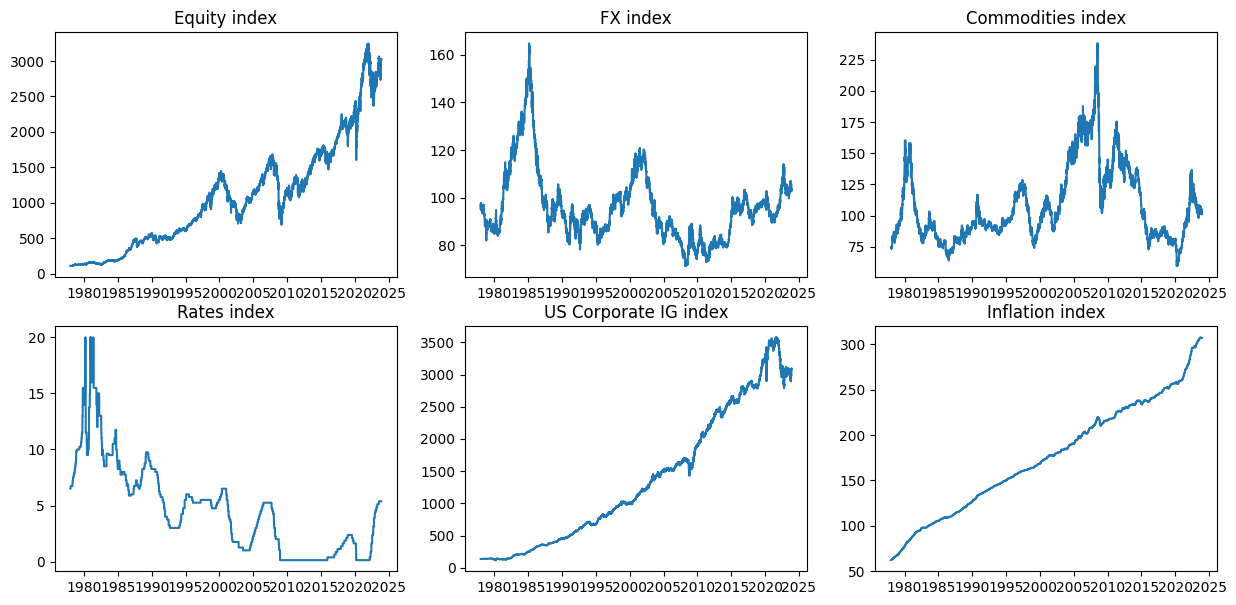

In [6]:
plt.figure(figsize=(15,7))

plt.subplot(2,3,1)
plt.plot(data["Equity"])
plt.title("Equity index")

plt.subplot(2,3,2)
plt.plot(data["FX"])
plt.title("FX index")

plt.subplot(2,3,3)
plt.plot(data["Commodities"])
plt.title("Commodities index")

plt.subplot(2,3,4)
plt.plot(data["Rates"])
plt.title("Rates index")

plt.subplot(2,3,5)
plt.plot(data["US Corporate IG"])
plt.title("US Corporate IG index")

plt.subplot(2,3,6)
plt.plot(data["Inflation"])
plt.title("Inflation index")

plt.show()

In [7]:
data.describe()

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
count,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000
mean,1066.751547,96.066655,108.078251,4.606244,176.225880,1368.124757
std,756.442063,14.847328,29.957682,4.015175,61.237558,1035.164681
min,103.900000,71.329000,59.479500,0.125000,62.100000,118.490000
25%,484.370000,86.230000,86.432000,1.000000,124.100000,433.100000
50%,989.670000,93.680000,97.418300,4.625000,174.100000,1086.890000
75%,1491.790000,100.830000,125.160800,6.750000,229.601000,2318.100000
max,3248.120000,164.720000,237.953100,20.000000,307.789000,3575.820000


## Risk Factor Lens

In [8]:
Lens=data.copy(deep=True)

# Calcul des rendements
for col in Lens.columns:
    Lens[col]=Lens[col].pct_change()

# ajustement des rendements
for col in Lens.columns:
    Lens[col]=Lens[col].values.reshape(-1,1)

# nettoyage
Lens=Lens.dropna()

Lens

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
Date,,,,,,
1977-12-30,-0.000092,-0.001346,-0.001878,0.0,0.000000,0.000000
1978-01-02,0.000553,-0.012754,0.008355,0.0,0.006441,-0.003496
1978-01-03,-0.003592,0.000000,0.000000,0.0,0.000000,0.000000
1978-01-04,0.000647,-0.002311,-0.010331,0.0,0.000000,0.000000
1978-01-05,-0.013856,0.030319,-0.001827,0.0,0.000000,0.000000
...,...,...,...,...,...,...
2023-11-24,0.002144,-0.004975,0.000000,0.0,0.000000,-0.003560
2023-11-27,-0.002388,-0.001973,-0.004445,0.0,0.000000,0.006919
2023-11-28,0.001523,-0.004390,0.009970,0.0,0.000000,0.003066


Vérification qu'il n'y a pas de NaN dans le tableau de données

In [9]:
Lens.isna().any()

Equity             False
FX                 False
Commodities        False
Rates              False
Inflation          False
US Corporate IG    False
dtype: bool

Description des indices utilisés après traitement

In [10]:
Lens.describe()

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
count,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000
mean,0.000318,0.000019,0.000068,0.000539,0.000134,0.000269
std,0.008922,0.005144,0.009071,0.035846,0.001005,0.004313
min,-0.099151,-0.034843,-0.087630,-0.888889,-0.019153,-0.080874
25%,-0.003753,-0.002750,-0.004694,0.000000,0.000000,-0.000845
50%,0.000525,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.004663,0.002811,0.004983,0.000000,0.000000,0.001498
max,0.095229,0.043457,0.065174,2.000000,0.015209,0.128872


# Matrice de corrélation des indices

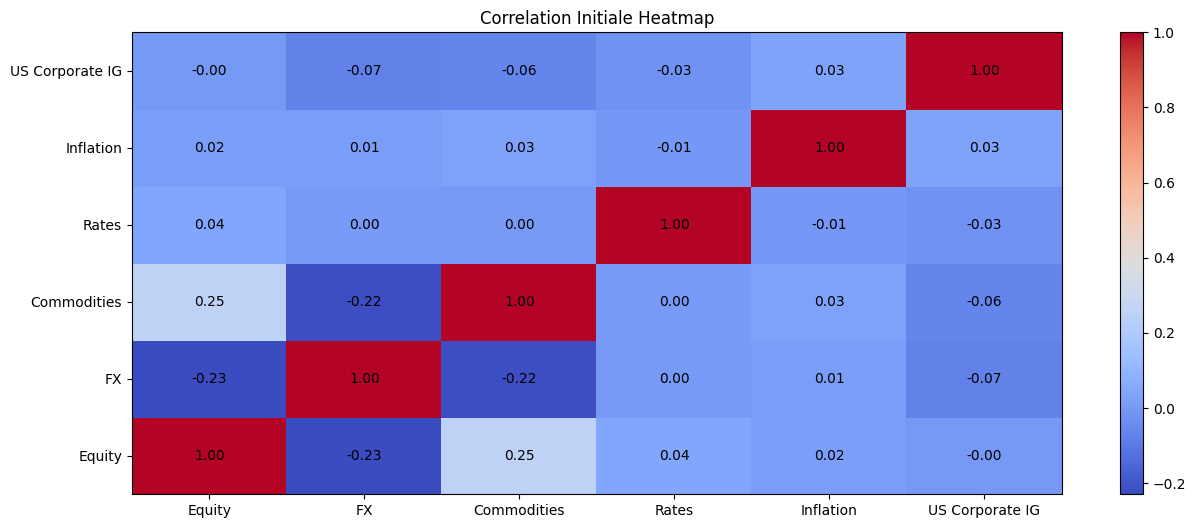

In [11]:
#corrélation
Correlation_initiale=Lens.corr()

# Create a heatmap using matplotlib
plt.figure(figsize=(15, 6))
heatmap = plt.pcolor(Correlation_initiale, cmap='coolwarm')

#Annotate the value in each cell
for i in range(len(Correlation_initiale)):
    for j in range(len(Correlation_initiale)):
        plt.text(j + 0.5, i + 0.5, f'{Correlation_initiale.iloc[i, j]:.2f}', ha='center', va='center', fontsize=10)


# Add colorbar
plt.colorbar(heatmap)

# Set ticks at the middle of each cell
plt.xticks(np.arange(0.5, len(Correlation_initiale.columns), 1), Correlation_initiale.columns)
plt.yticks(np.arange(0.5, len(Correlation_initiale.index), 1), Correlation_initiale.columns)


plt.title('Correlation Initiale Heatmap')
plt.show()

In [12]:
Correlation_initiale

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
Equity,1.000000,-0.229491,0.254221,0.040842,0.019415,-0.001405
FX,-0.229491,1.000000,-0.224381,0.004605,0.014646,-0.073482
Commodities,0.254221,-0.224381,1.000000,0.002050,0.028322,-0.064707
Rates,0.040842,0.004605,0.002050,1.000000,-0.005627,-0.025422
Inflation,0.019415,0.014646,0.028322,-0.005627,1.000000,0.029867
US Corporate IG,-0.001405,-0.073482,-0.064707,-0.025422,0.029867,1.000000


## Exponentially-weighted regression

In [13]:
Lens_adj=Lens.copy(deep=True) #copie du dataframe Lens où l'on va appliquer la régression exponentielle.
Lens_adj

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
Date,,,,,,
1977-12-30,-0.000092,-0.001346,-0.001878,0.0,0.000000,0.000000
1978-01-02,0.000553,-0.012754,0.008355,0.0,0.006441,-0.003496
1978-01-03,-0.003592,0.000000,0.000000,0.0,0.000000,0.000000
1978-01-04,0.000647,-0.002311,-0.010331,0.0,0.000000,0.000000
1978-01-05,-0.013856,0.030319,-0.001827,0.0,0.000000,0.000000
...,...,...,...,...,...,...
2023-11-24,0.002144,-0.004975,0.000000,0.0,0.000000,-0.003560
2023-11-27,-0.002388,-0.001973,-0.004445,0.0,0.000000,0.006919
2023-11-28,0.001523,-0.004390,0.009970,0.0,0.000000,0.003066


In [14]:
# Define the rolling window size
rolling_window = 252  # Assuming daily returns with approximately 252 trading days in a year

# Exponentially weighted residualization process using pd.ewm()
def ewm_residualize(donnees, dependent_column, independent_columns, span):
    result = pd.DataFrame(index=donnees.index)

    for col in independent_columns:
        # Calculate EWMA of the independent variable
        ewma_x = donnees[col].ewm(span=span).mean()

        # Calculate EWMA of the dependent variable
        ewma_y = donnees[dependent_column].ewm(span=span).mean()

        # Calculate residuals using rolling regression
        residuals = donnees[dependent_column] - ewma_y
        for i in range(rolling_window, len(donnees)):
            window_data = donnees[i - rolling_window:i + 1]
            window_ewma_x = ewma_x[i - rolling_window:i + 1]

            # Rolling regression to calculate residuals
            X = np.column_stack((np.ones_like(window_ewma_x), window_ewma_x))
            beta = np.linalg.lstsq(X, window_data[dependent_column], rcond=None)[0]
            residuals.iloc[i] = window_data[dependent_column].iloc[-1] - np.dot(X[-1, :], beta)

        result[col + '_residual'] = residuals

    return result

# Utilisation de la régression exponentielle sur les données

In [15]:
span_parameter = 20  # Adjust span parameter based on preferences
for i in range(1,len(Lens_adj.columns)):
    residualized_data = ewm_residualize(Lens_adj, Lens_adj.columns[i], Lens_adj.columns[:i], span_parameter)
    for d in range(len(Lens_adj.index)):
        for j in residualized_data.columns:
            Lens_adj.iloc[d,i]=Lens_adj.iloc[d,i]-residualized_data[j].iloc[d]

Lens_adj

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
Date,,,,,,
1977-12-30,-0.000092,-0.001346,-0.001878,0.000000,0.000000,0.000000
1978-01-02,0.000553,-0.007335,-0.001366,0.000000,-0.005797,0.004807
1978-01-03,-0.003592,-0.004642,0.004422,0.000000,0.008560,-0.005807
1978-01-04,0.000647,-0.003969,0.007512,0.000000,0.006089,-0.004131
1978-01-05,-0.013856,0.004325,-0.001194,0.000000,0.004616,-0.003132
...,...,...,...,...,...,...
2023-11-24,0.002144,-0.000766,0.001558,0.006504,0.000616,0.014809
2023-11-27,-0.002388,-0.000621,0.005439,0.006587,0.000611,-0.027411
2023-11-28,0.001523,-0.000618,-0.008954,0.006059,0.000584,-0.011765


In [16]:
Lens_adj.isna().any()

Equity             False
FX                 False
Commodities        False
Rates              False
Inflation          False
US Corporate IG    False
dtype: bool

In [17]:
Lens_adj.describe()

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
count,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000
mean,0.000318,0.000015,0.000029,0.000155,0.000152,0.000243
std,0.008922,0.000882,0.008935,0.070506,0.002966,0.016891
min,-0.099151,-0.007335,-0.070867,-3.954878,-0.040881,-0.471607
25%,-0.003753,-0.000457,-0.004793,-0.002303,0.000269,-0.004894
50%,0.000525,0.000010,-0.000063,0.000000,0.000433,0.000987
75%,0.004663,0.000418,0.004828,0.003025,0.000640,0.005494
max,0.095229,0.007540,0.085430,1.723478,0.056144,0.319440


# Matrice de corrélation après régression


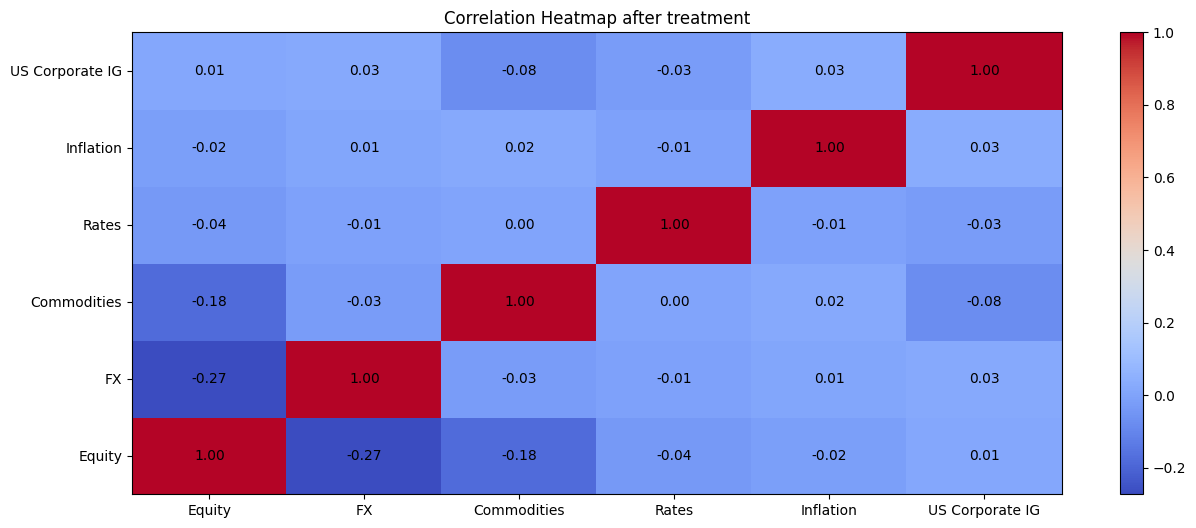

In [18]:
#corrélation
Correlation_apres_traitement=Lens_adj.corr()

# Create a heatmap using matplotlib
plt.figure(figsize=(15, 6))
heatmap = plt.pcolor(Correlation_apres_traitement, cmap='coolwarm')

#Annotate the value in each cell
for i in range(len(Correlation_apres_traitement)):
    for j in range(len(Correlation_apres_traitement)):
        plt.text(j + 0.5, i + 0.5, f'{Correlation_apres_traitement.iloc[i, j]:.2f}', ha='center', va='center', fontsize=10)

# Add colorbar
plt.colorbar(heatmap)

# Set ticks at the middle of each cell
plt.xticks(np.arange(0.5, len(Correlation_apres_traitement.columns), 1), Correlation_apres_traitement.columns)
plt.yticks(np.arange(0.5, len(Correlation_apres_traitement.index), 1), Correlation_apres_traitement.columns)


plt.title('Correlation Heatmap after treatment')
plt.show()

In [19]:
Correlation_initiale #Corrélations avant regression exponentielle

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
Equity,1.000000,-0.229491,0.254221,0.040842,0.019415,-0.001405
FX,-0.229491,1.000000,-0.224381,0.004605,0.014646,-0.073482
Commodities,0.254221,-0.224381,1.000000,0.002050,0.028322,-0.064707
Rates,0.040842,0.004605,0.002050,1.000000,-0.005627,-0.025422
Inflation,0.019415,0.014646,0.028322,-0.005627,1.000000,0.029867
US Corporate IG,-0.001405,-0.073482,-0.064707,-0.025422,0.029867,1.000000


In [20]:
Correlation_apres_traitement #Corrélations après régression exponentielle

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
Equity,1.000000,-0.272759,-0.181464,-0.036450,-0.018434,0.010794
FX,-0.272759,1.000000,-0.028719,-0.006325,0.009335,0.025357
Commodities,-0.181464,-0.028719,1.000000,0.003505,0.022868,-0.075124
Rates,-0.036450,-0.006325,0.003505,1.000000,-0.006414,-0.028951
Inflation,-0.018434,0.009335,0.022868,-0.006414,1.000000,0.030916
US Corporate IG,0.010794,0.025357,-0.075124,-0.028951,0.030916,1.000000


In [21]:
Correlation_apres_traitement-Correlation_initiale #Différences entre les deux matrices

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG
Equity,0.000000,-0.043268,-0.435685,-0.077293,-0.037850,0.012199
FX,-0.043268,0.000000,0.195661,-0.010930,-0.005311,0.098838
Commodities,-0.435685,0.195661,0.000000,0.001455,-0.005454,-0.010417
Rates,-0.077293,-0.010930,0.001455,0.000000,-0.000788,-0.003529
Inflation,-0.037850,-0.005311,-0.005454,-0.000788,0.000000,0.001049
US Corporate IG,0.012199,0.098838,-0.010417,-0.003529,0.001049,0.000000


# GMM

In [22]:
# Création des dataset pour s'entrainer et tester
df_train = Lens_adj[Lens_adj.index<pd.to_datetime('2007-01-01')]
df_test = Lens_adj[Lens_adj.index>pd.to_datetime('2007-01-01')]

num_states = 4  # Définissez le nombre d'états de marché

Etats=[i for i in range(num_states)]
Col_res=Lens_adj.columns.to_list()
Col_res.append('Market_State')
for j in Etats:
    Col_res.append(j)

model = GaussianMixture(n_components=num_states)

# Ajustez le modèle
model.fit(df_train)

# 4. Identification des états de marché
market_states = model.predict(df_test)
Proba_market_states=model.predict_proba(df_test)

# Ajoutez les états de marché en tant que colonne dans les données
res=np.column_stack((df_test, market_states,Proba_market_states))
res=pd.DataFrame(res,index=df_test.index,columns=Col_res)
res #rendements journaliers

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG,Market_State,0,1,2,3
Date,,,,,,,,,,,
2007-01-02,0.007239,-0.000765,0.001627,0.001492,0.000216,0.001025,0.0,0.999007,0.000500,7.147568e-08,0.000493
2007-01-03,-0.003808,-0.000382,0.000540,0.001467,0.000221,-0.006589,0.0,0.998962,0.000604,9.413125e-08,0.000434
2007-01-04,-0.002875,-0.000144,0.011736,0.001162,0.000193,-0.010804,0.0,0.997300,0.001630,2.108350e-07,0.001070
2007-01-05,-0.009802,0.000514,0.005292,0.000899,0.000181,0.005988,0.0,0.998508,0.000913,2.081193e-07,0.000579
2007-01-08,0.001075,0.000411,0.003385,0.001015,0.000200,0.000751,0.0,0.999253,0.000362,5.348720e-08,0.000385
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,0.002144,-0.000766,0.001558,0.006504,0.000616,0.014809,0.0,0.997471,0.000843,4.853451e-07,0.001686
2023-11-27,-0.002388,-0.000621,0.005439,0.006587,0.000611,-0.027411,0.0,0.947654,0.043570,2.720693e-05,0.008750
2023-11-28,0.001523,-0.000618,-0.008954,0.006059,0.000584,-0.011765,0.0,0.997472,0.001097,4.214927e-07,0.001431


In [23]:
res_annuel=res.copy(deep=True)
stop=0

for i in range(len(res_annuel.columns)):
    if res_annuel.columns[i]=='Market_State':
        stop=i

for col in res_annuel.columns[:stop]:
    res_annuel[col]=res_annuel[col]*np.sqrt(252)*100

res_annuel

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG,Market_State,0,1,2,3
Date,,,,,,,,,,,
2007-01-02,11.491946,-1.214813,2.583377,2.368716,0.342684,1.626929,0.0,0.999007,0.000500,7.147568e-08,0.000493
2007-01-03,-6.044619,-0.606038,0.857296,2.329247,0.350275,-10.459300,0.0,0.998962,0.000604,9.413125e-08,0.000434
2007-01-04,-4.564122,-0.229160,18.629578,1.844451,0.305641,-17.151161,0.0,0.997300,0.001630,2.108350e-07,0.001070
2007-01-05,-15.560622,0.816714,8.400230,1.427752,0.287646,9.505276,0.0,0.998508,0.000913,2.081193e-07,0.000579
2007-01-08,1.706472,0.652343,5.373583,1.611530,0.318051,1.191475,0.0,0.999253,0.000362,5.348720e-08,0.000385
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,3.403105,-1.215768,2.472961,10.325437,0.978208,23.508703,0.0,0.997471,0.000843,4.853451e-07,0.001686
2023-11-27,-3.790688,-0.985743,8.634917,10.456331,0.970413,-43.512916,0.0,0.947654,0.043570,2.720693e-05,0.008750
2023-11-28,2.417071,-0.981198,-14.214518,9.618565,0.926710,-18.675767,0.0,0.997472,0.001097,4.214927e-07,0.001431


# Frise chronologique sur les états de marché dominants

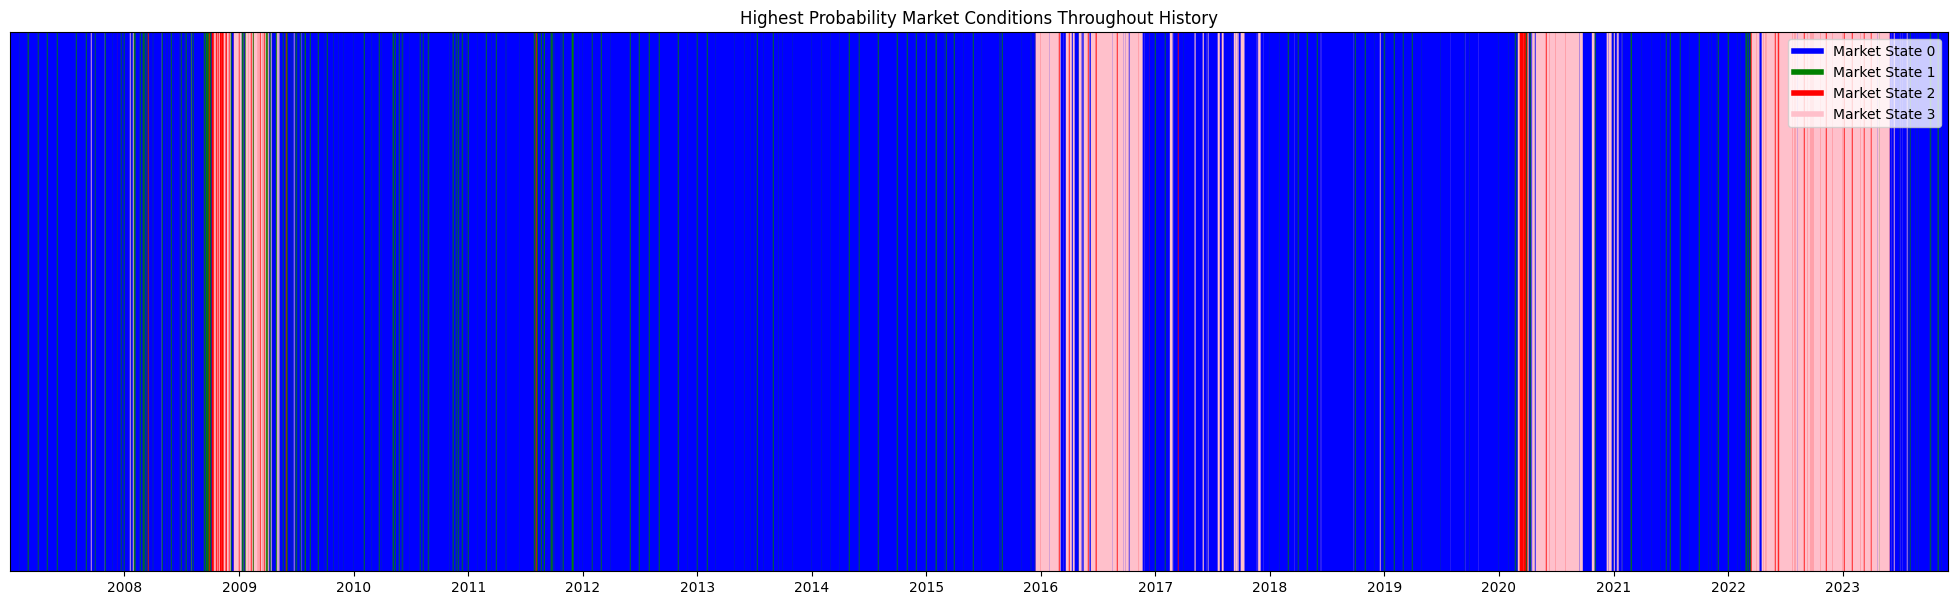

In [24]:
# Couleurs pour chaque régime de marché
colors = {'0': 'blue', '1': 'green', '2': 'red', '3': 'pink'}

# Création d'une figure pour la frise
fig, ax = plt.subplots(figsize=(25, 7))

# Hauteur du rectangle pour la frise
rectangle_height = 1

# Tracé des rectangles pour chaque date
for i, date in enumerate(res.index):
    # Déterminer la couleur en fonction du régime de marché
    market_state = str(int(res.at[date, 'Market_State']))  # Conversion en chaîne après conversion en entier
    color = colors[market_state]

    # Création du rectangle
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

# Configuration de l'axe des x pour afficher uniquement les années
years = [date.year for date in res.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

# Configuration des limites de l'axe
ax.set_xlim(0, len(res))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([])  # Pas de marques sur l'axe des y

# Création d'une légende pour les états de marché
legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'Market State {state}') for state, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

# Titre et affichage du graphique
ax.set_title('Highest Probability Market Conditions Throughout History')
plt.show()

# Affichage des résulats

In [25]:
# Affichez les statistiques des différents états de marché en bp
for state in range(num_states):
    state_data = res_annuel[res_annuel['Market_State'] == state]
    print("\n ------------------------------------------- \n")
    print(f"État de marché {state} - Nombre d'observations : {len(state_data)}")
    print(state_data.iloc[:,:stop].describe())


 ------------------------------------------- 

État de marché 0 - Nombre d'observations : 3270
            Equity           FX  Commodities        Rates    Inflation  \
count  3270.000000  3270.000000  3270.000000  3270.000000  3270.000000   
mean      0.604477     0.056972    -0.078734     0.894831     0.585918   
std      11.788410     1.255259    13.167408     9.861280     0.560428   
min     -49.636621    -5.726405   -55.018230   -30.343255    -5.556314   
25%      -5.463879    -0.700342    -7.691465     0.000000     0.335772   
50%       1.026578     0.060187    -0.084235     0.000000     0.489074   
75%       7.393210     0.734808     7.798996     2.309019     0.757088   
max      49.004346     5.741477    63.041945    29.747137     6.577454   

       US Corporate IG  
count      3270.000000  
mean          0.460455  
std          17.347923  
min         -51.121104  
25%         -10.856261  
50%           0.339790  
75%          11.131044  
max          53.714299  

 ----------

# Résulats avec les données initiales

In [26]:
res2=data.copy(deep=True)
res2=res2[res2.index.year>=2007]
res2=res2.iloc[1:,:]
res2["Market_State"]=res["Market_State"]
res2

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG,Market_State
Date,,,,,,,
2007-01-02,1494.32,83.270,161.1722,5.250,202.416,1603.49,0.0
2007-01-03,1488.63,83.920,161.1722,5.250,202.416,1606.49,0.0
2007-01-04,1484.35,84.340,159.2099,5.250,202.416,1611.21,0.0
2007-01-05,1469.80,84.640,157.9537,5.250,202.416,1609.08,0.0
2007-01-08,1471.38,84.570,157.0678,5.250,202.416,1609.07,0.0
...,...,...,...,...,...,...,...
2023-11-24,3015.19,103.403,101.4189,5.375,307.051,3045.11,0.0
2023-11-27,3007.99,103.199,100.9681,5.375,307.051,3066.18,0.0
2023-11-28,3012.57,102.746,101.9748,5.375,307.051,3075.58,0.0


In [27]:
# Affichez les statistiques des différents états de marché en bp
for state in range(num_states):
    state_data = res2[res2['Market_State'] == state]
    print("\n ------------------------------------------- \n")
    print(f"État de marché {state} - Nombre d'observations : {len(state_data)}")
    print(state_data.iloc[:,:stop].describe())


 ------------------------------------------- 

État de marché 0 - Nombre d'observations : 3270
            Equity           FX  Commodities        Rates    Inflation  \
count  3270.000000  3270.000000  3270.000000  3270.000000  3270.000000   
mean   1788.968456    87.326972   120.698882     1.144992   239.015836   
std     570.804251     8.847843    35.353749     1.621323    22.447533   
min     835.520000    71.329000    59.552800     0.125000   202.416000   
25%    1336.360000    79.981000    87.317750     0.125000   221.309000   
50%    1663.755000    84.700000   123.242200     0.125000   236.119000   
75%    2104.525000    95.717500   141.648450     1.875000   252.006000   
max    3248.120000   107.000000   237.953100     5.375000   307.789000   

       US Corporate IG  
count      3270.000000  
mean       2513.059896  
std         553.823169  
min        1516.510000  
25%        2081.937500  
50%        2532.670000  
75%        2865.755000  
max        3575.820000  

 ----------

In [28]:
res2.describe()

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG,Market_State
count,4413.000000,4413.000000,4413.000000,4413.000000,4413.000000,4413.000000,4413.000000
mean,1829.836467,89.171642,116.942161,1.194964,242.965954,2553.286524,0.631543
std,602.306448,9.598490,35.007680,1.626842,26.044602,573.987754,1.152365
min,688.640000,71.329000,59.479500,0.125000,202.416000,1432.060000,0.000000
25%,1343.810000,80.392000,85.835400,0.125000,223.467000,2096.310000,0.000000
50%,1695.540000,90.455000,112.199700,0.125000,237.852000,2585.270000,0.000000
75%,2166.660000,96.958000,137.301900,1.875000,256.558000,2978.460000,1.000000
max,3248.120000,114.106000,237.953100,5.375000,307.789000,3575.820000,3.000000


# Écriture des probas dans le fichier GMM_Proba

In [29]:
# Chemin du fichier CSV
chemin_fichier_csv = "GMM_Proba.csv"

#res.iloc[:,stop:].to_csv(chemin_fichier_csv,index=True)

# **HMM**

# Echantillon d'entrainement et échantillon de test

In [30]:
df_train_HMM=res[res.index.year<2018]
df_test_HMM=res[res.index.year>=2018]
#print(df_train_HMM.shape)
df_test_HMM

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG,Market_State,0,1,2,3
Date,,,,,,,,,,,
2018-01-01,0.000010,-0.000384,-0.002471,0.001032,-0.015857,0.018471,1.0,2.161194e-45,0.999627,3.728812e-04,1.713364e-40
2018-01-02,0.005976,-0.000251,0.000445,0.003244,0.000477,0.000487,0.0,9.991052e-01,0.000345,6.704958e-08,5.499336e-04
2018-01-03,0.004542,-0.000116,-0.001593,0.004235,0.000474,-0.005723,0.0,9.988652e-01,0.000384,9.533746e-08,7.510002e-04
2018-01-04,0.008045,-0.000024,0.001354,0.006608,0.000464,0.001759,0.0,9.985053e-01,0.000334,1.788673e-07,1.160231e-03
2018-01-05,0.006464,0.000159,0.008098,0.010275,0.000422,0.004340,0.0,9.958537e-01,0.000282,7.926535e-07,3.863909e-03
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,0.002144,-0.000766,0.001558,0.006504,0.000616,0.014809,0.0,9.974710e-01,0.000843,4.853451e-07,1.685987e-03
2023-11-27,-0.002388,-0.000621,0.005439,0.006587,0.000611,-0.027411,0.0,9.476536e-01,0.043570,2.720693e-05,8.749520e-03
2023-11-28,0.001523,-0.000618,-0.008954,0.006059,0.000584,-0.011765,0.0,9.974721e-01,0.001097,4.214927e-07,1.430513e-03


# Création du modèle

In [31]:
num_states=4

model_HMM = hmm.GaussianHMM(n_components=num_states, covariance_type='full',n_iter = 10000, random_state = 10000)
model_HMM.fit(df_train_HMM.iloc[:,:stop+1])
market_states_HMM = model_HMM.predict(df_test_HMM.iloc[:,:stop+1])
Proba_market_states_HMM=model_HMM.predict_proba(df_test_HMM.iloc[:,:stop+1])


# Ajoutez les états de marché en tant que colonne dans les données
res_HMM=np.column_stack((df_test_HMM.iloc[:,:stop+1], market_states_HMM,Proba_market_states_HMM))
res_HMM=pd.DataFrame(res_HMM,index=df_test_HMM.index,columns=["Equity","FX","Commodities","Rates","Inflation","US Corporate IG","Market_State GMM","Market_State HMM","0","1","2","3"])

In [32]:
df_train_HMM

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG,Market_State,0,1,2,3
Date,,,,,,,,,,,
2007-01-02,0.007239,-0.000765,0.001627,0.001492,0.000216,0.001025,0.0,0.999007,0.000500,7.147568e-08,0.000493
2007-01-03,-0.003808,-0.000382,0.000540,0.001467,0.000221,-0.006589,0.0,0.998962,0.000604,9.413125e-08,0.000434
2007-01-04,-0.002875,-0.000144,0.011736,0.001162,0.000193,-0.010804,0.0,0.997300,0.001630,2.108350e-07,0.001070
2007-01-05,-0.009802,0.000514,0.005292,0.000899,0.000181,0.005988,0.0,0.998508,0.000913,2.081193e-07,0.000579
2007-01-08,0.001075,0.000411,0.003385,0.001015,0.000200,0.000751,0.0,0.999253,0.000362,5.348720e-08,0.000385
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,0.000167,-0.000319,-0.011347,0.003433,0.000253,-0.006850,0.0,0.998380,0.000985,1.603795e-07,0.000635
2017-12-26,-0.000300,-0.000283,0.000050,0.003926,0.000248,0.001188,0.0,0.999211,0.000283,6.682624e-08,0.000507
2017-12-27,0.001848,-0.000303,-0.003785,0.003560,0.000251,-0.016032,0.0,0.996420,0.002335,5.150542e-07,0.001245


In [33]:
derniere_obs=df_train_HMM["Market_State"][-1].reshape(1,-1)
futurs_etats=[]

for j in range(3):
  etat_suivant=model_HMM.predict(derniere_obs)
  futurs_etats.append(etat_suivant)
  derniere_obs=model_HMM.means_[etat_suivant]

print(futurs_etats)

[array([2]), array([2]), array([2])]


In [34]:
res_HMM

,Equity,FX,Commodities,Rates,Inflation,US Corporate IG,Market_State GMM,Market_State HMM,0,1,2,3
Date,,,,,,,,,,,,
2018-01-01,0.000010,-0.000384,-0.002471,0.001032,-0.015857,0.018471,1.0,0.0,1.000000e+00,0.0,0.0,0.000000e+00
2018-01-02,0.005976,-0.000251,0.000445,0.003244,0.000477,0.000487,0.0,2.0,7.282378e-10,0.0,1.0,8.157186e-18
2018-01-03,0.004542,-0.000116,-0.001593,0.004235,0.000474,-0.005723,0.0,2.0,3.227264e-10,0.0,1.0,4.637924e-18
2018-01-04,0.008045,-0.000024,0.001354,0.006608,0.000464,0.001759,0.0,2.0,4.966658e-10,0.0,1.0,4.317994e-18
2018-01-05,0.006464,0.000159,0.008098,0.010275,0.000422,0.004340,0.0,2.0,9.071443e-10,0.0,1.0,8.539439e-18
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,0.002144,-0.000766,0.001558,0.006504,0.000616,0.014809,0.0,2.0,1.540048e-09,0.0,1.0,7.081244e-18
2023-11-27,-0.002388,-0.000621,0.005439,0.006587,0.000611,-0.027411,0.0,2.0,7.298524e-09,0.0,1.0,3.157916e-16
2023-11-28,0.001523,-0.000618,-0.008954,0.006059,0.000584,-0.011765,0.0,2.0,1.132943e-09,0.0,1.0,5.968805e-17


# Précision du modèle

In [35]:
c=0
n=len(res_HMM.index)
for i in res_HMM.index:
  if res_HMM.loc[i,('Market_State HMM')]==0 and res_HMM.loc[i,('Market_State GMM')]==1:
    c+=1
  if res_HMM.loc[i,('Market_State HMM')]==1 and res_HMM.loc[i,('Market_State GMM')]==0:
    c+=1
  if res_HMM.loc[i,('Market_State HMM')]==2 and res_HMM.loc[i,('Market_State GMM')]==2:
    c+=1
  if res_HMM.loc[i,('Market_State HMM')]==3 and res_HMM.loc[i,('Market_State GMM')]==3:
    c+=1
print(f"La précision du modèle à T+1 est : {round((c/n)*100,4)}%")

La précision du modèle à T+1 est : 7.0596%


# Matrice de transition

In [36]:
print(model_HMM.transmat_)

[[0.15601209 0.02272995 0.79565831 0.02559966]
 [0.01824687 0.78461534 0.11078105 0.08635674]
 [0.07593523 0.01330434 0.90281058 0.00794985]
 [0.09227926 0.49662152 0.14171318 0.26938603]]


# Frise Chronologique HMM

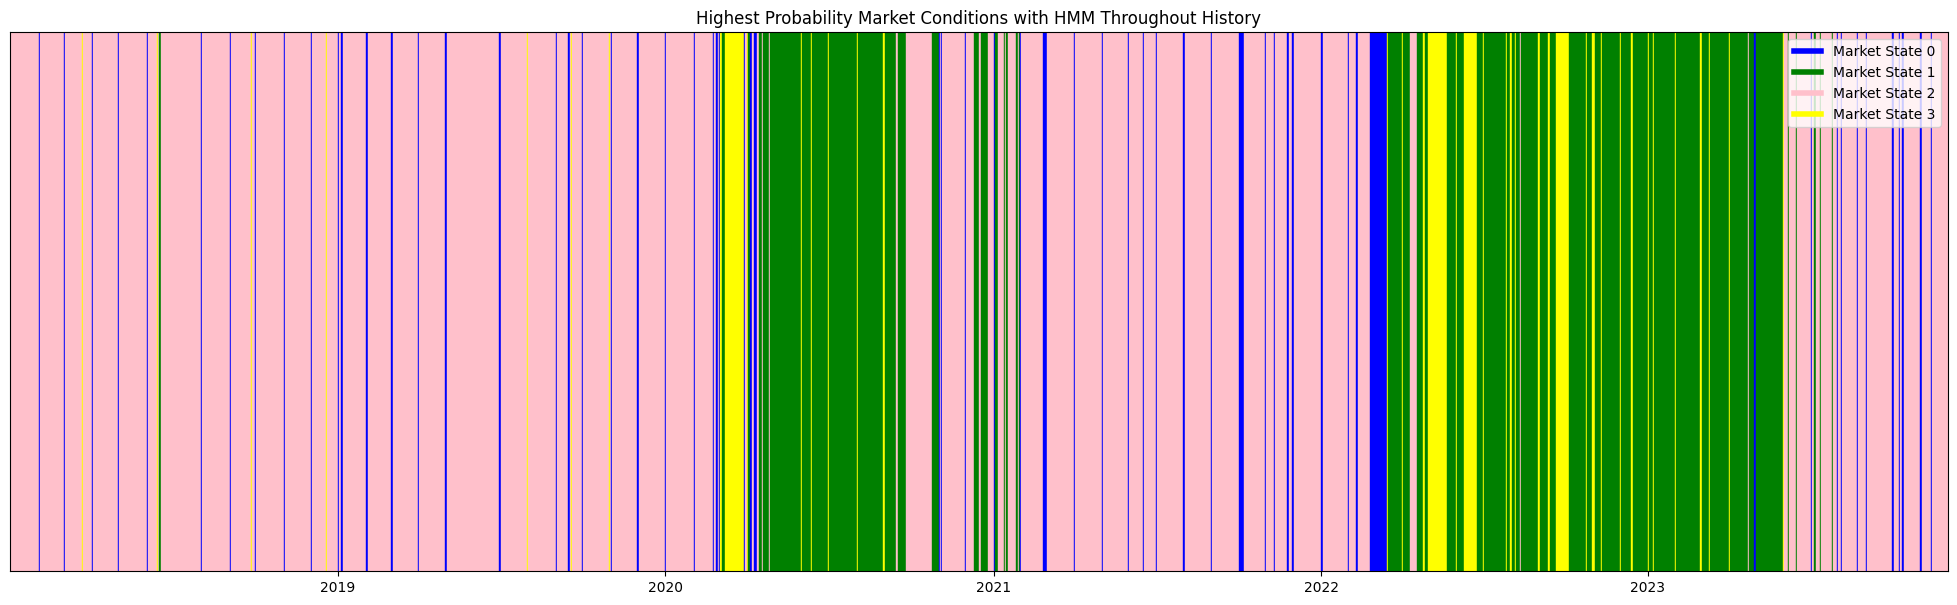

In [37]:
# Couleurs pour chaque régime de marché
colors = {'0': 'blue', '1': 'green', '2': 'pink','3': 'yellow'}

# Création d'une figure pour la frise
fig, ax = plt.subplots(figsize=(25, 7))

# Hauteur du rectangle pour la frise
rectangle_height = 1

# Tracé des rectangles pour chaque date
for i, date in enumerate(res_HMM.index):
    # Déterminer la couleur en fonction du régime de marché
    market_state = str(int(res_HMM.at[date, 'Market_State HMM']))  # Conversion en chaîne après conversion en entier
    color = colors[market_state]

    # Création du rectangle
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

# Configuration de l'axe des x pour afficher uniquement les années
years = [date.year for date in res_HMM.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

# Configuration des limites de l'axe
ax.set_xlim(0, len(res_HMM))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([])  # Pas de marques sur l'axe des y

# Création d'une légende pour les états de marché
legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'Market State {state}') for state, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

# Titre et affichage du graphique
ax.set_title('Highest Probability Market Conditions with HMM Throughout History')
plt.show()

# ZOOM sur la frise GMM sur la période 2018-2024

In [38]:
res_GMM=res[res.index.year>=2018]

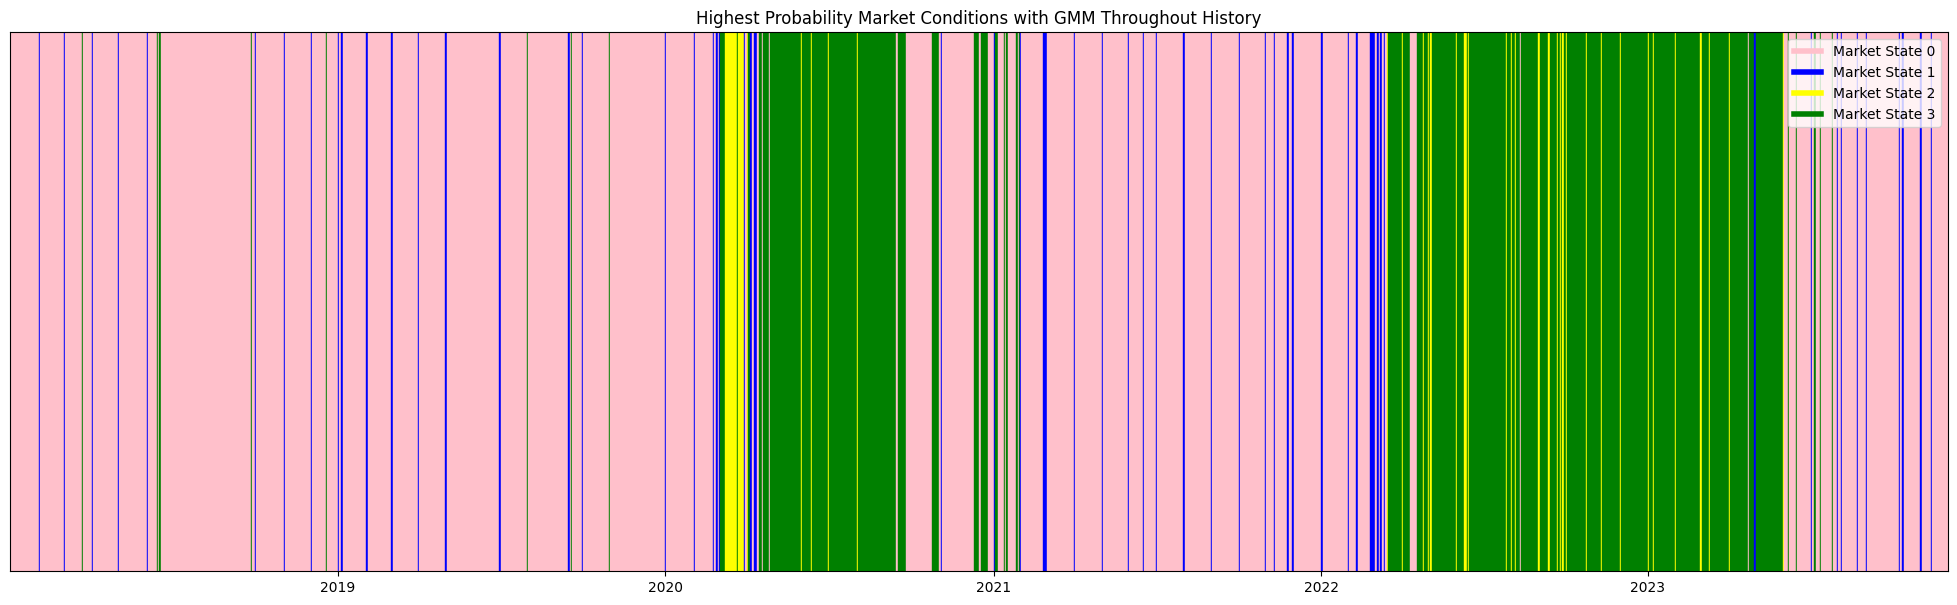

In [40]:
# Couleurs pour chaque régime de marché
colors = {'0': 'pink', '1': 'blue', '2': 'yellow', '3': 'green'}

# Création d'une figure pour la frise
fig, ax = plt.subplots(figsize=(25, 7))

# Hauteur du rectangle pour la frise
rectangle_height = 1

# Tracé des rectangles pour chaque date
for i, date in enumerate(res_GMM.index):
    # Déterminer la couleur en fonction du régime de marché
    market_state = str(int(res_GMM.at[date, 'Market_State']))  # Conversion en chaîne après conversion en entier
    color = colors[market_state]

    # Création du rectangle
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

# Configuration de l'axe des x pour afficher uniquement les années
years = [date.year for date in res_GMM.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

# Configuration des limites de l'axe
ax.set_xlim(0, len(res_GMM))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([])  # Pas de marques sur l'axe des y

# Création d'une légende pour les états de marché
legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'Market State {state}') for state, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

# Titre et affichage du graphique
ax.set_title('Highest Probability Market Conditions with GMM Throughout History')
plt.show()